### Importing the requried libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import csv
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers.embeddings import Embedding
from keras.layers import Dropout


Using TensorFlow backend.


### Mounting the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Reading the data from csv file

In [0]:
df = pd.read_csv('/content/drive/My Drive/finalcleandataTraining.csv')
#print(df.head())
xdata = df['message']
y_label = df[["toxic", "obscene", "insult", "racism", "sexism"]]
ydata = y_label.values

### Splitting the data into Training & Testing

In [0]:
xtrain,xtest,y_train,ytest = train_test_split(xdata,ydata,test_size=0.2) 

### Creating the embedding dictionary

In [0]:
maxlen = 64
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(xtrain)
vocab_size = len(tokenizer.word_index) + 1

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/Prj/glove.twitter.27B.200d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:])
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

### Creating the embedding matrix from embedding dictionary

In [0]:
embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Creating the model

In [12]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(32, return_sequences=True)(embedding_layer)
LSTM_Layer_2 = LSTM(32, return_sequences=True)(LSTM_Layer_1)
Dropout_Layer = Dropout(0.5)(LSTM_Layer_2)
LSTM_Layer_3 = LSTM(32)(Dropout_Layer)
dense_layer_1 = Dense(5, activation='sigmoid')(LSTM_Layer_3)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 200)           7338400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 32)            29824     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64, 32)            8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165 

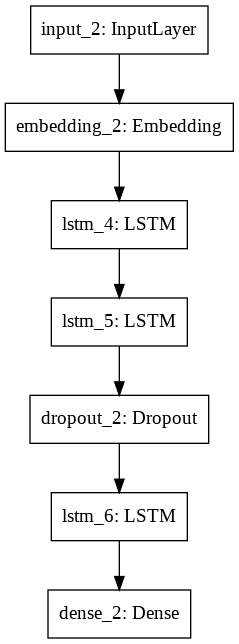

In [13]:
model.summary()
plot_model(model, to_file='model.png')

### Training the model

In [14]:
X_train = tokenizer.texts_to_sequences(xtrain)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.2)



Train on 8988 samples, validate on 2248 samples
Epoch 1/20
8988/8988 [==============================] - 15s 2ms/step - loss: 0.5677 - acc: 0.8022 - val_loss: 0.4711 - val_acc: 0.8133
Epoch 2/20
8988/8988 [==============================] - 12s 1ms/step - loss: 0.4705 - acc: 0.8145 - val_loss: 0.4664 - val_acc: 0.8133
Epoch 3/20
8988/8988 [==============================] - 12s 1ms/step - loss: 0.4621 - acc: 0.8145 - val_loss: 0.4515 - val_acc: 0.8133
Epoch 4/20
8988/8988 [==============================] - 12s 1ms/step - loss: 0.4431 - acc: 0.8145 - val_loss: 0.4300 - val_acc: 0.8133
Epoch 5/20
8988/8988 [==============================] - 13s 1ms/step - loss: 0.4166 - acc: 0.8164 - val_loss: 0.3869 - val_acc: 0.8265
Epoch 6/20
8988/8988 [==============================] - 13s 1ms/step - loss: 0.3496 - acc: 0.8419 - val_loss: 0.3602 - val_acc: 0.8362
Epoch 7/20
8988/8988 [==============================] - 13s 1ms/step - loss: 0.3138 - acc: 0.8626 - val_loss: 0.3072 - val_acc: 0.8651
Epoch

Saving the Model

In [0]:
model.save('Model_final.h5')

### Testing and evaluating the model

In [16]:
X_test = tokenizer.texts_to_sequences(xtest)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_test)
print(model.metrics_names)
model.evaluate(X_test,ytest, batch_size=128)

[[  84  893  339 ...    0    0    0]
 [   1  437 3234 ...    0    0    0]
 [3975 4701 6520 ...  210  619  210]
 ...
 [  34    8    1 ...    0    0    0]
 [  24  231  296 ...    1  625 3245]
 [  24    7   12 ...    0    0    0]]
['loss', 'acc']
2810/2810 [==============================] - 1s 394us/step


[0.22030713183811976, 0.9129537628638786]